In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import os
import cv2

In [2]:
Epochs = 2500 #3000
# Number of images to process:
M =1000 # Use 1000 to transform all the images in the flowers dataset

## Load the dataset

In [3]:
data_name = "flowers" # mit_1003  # landscapes # flowers

path_results = f"/nobackup/users/vianajr/saliency_xai/results/{data_name}"
path_models = f"/nobackup/users/vianajr/saliency_xai/models/{data_name}"

In [4]:
data = np.load(path_results + '/results.npz', allow_pickle=True)

In [5]:
X = data['var_treat_ims']
Y = data['var_orig_ims']
print(X.shape)
print(Y.shape)

(1000, 256, 256, 3)
(1000, 256, 256, 3)


In [6]:
X=X[:M]
Y=Y[:M]

In [7]:
x_shape = X.shape
N = x_shape[0]
print(X.shape)
print(Y.shape)

(1000, 256, 256, 3)
(1000, 256, 256, 3)


In [8]:
del data

In [9]:
x_train = X[:int(0.6*N)]
x_test = X[int(0.6*N):]

y_train = Y[:int(0.6*N)]
y_test = Y[int(0.6*N):]

In [10]:
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(600, 256, 256, 3)
(400, 256, 256, 3)
(600, 256, 256, 3)
(400, 256, 256, 3)


### Define a convolutional autoencoder

In [11]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(x_shape[1], x_shape[2], 3)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

2022-11-17 03:04:51.444668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31034 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0


In [12]:
autoencoder.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=losses.MeanSquaredError())

In [13]:
history = autoencoder.fit(x_train, y_train,
                          epochs=Epochs,
                          shuffle=True,
                          validation_data=(x_test, y_test))

2022-11-17 03:04:52.795963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2500


2022-11-17 03:04:53.671325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-17 03:04:54.047087: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 03:04:54.047520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 03:04:54.047545: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-11-17 03:04:54.048091: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-17 03:04:54.048172: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


19/19 [==============================] - 3s 80ms/step - loss: 0.0941 - val_loss: 0.0917
Epoch 2/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0937 - val_loss: 0.0914
Epoch 3/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0934 - val_loss: 0.0911
Epoch 4/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0931 - val_loss: 0.0908
Epoch 5/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0926 - val_loss: 0.0902
Epoch 6/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0919 - val_loss: 0.0893
Epoch 7/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0908 - val_loss: 0.0880
Epoch 8/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0890 - val_loss: 0.0858
Epoch 9/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0863 - val_loss: 0.0830
Epoch 10/2500
19/19 [==============================] - 1s 36ms/step - loss: 0.0835 - val_loss: 0.0807
Ep

In [14]:
encoded_imgs_ts = autoencoder.encoder(x_test).numpy()
decoded_imgs_ts = autoencoder.decoder(encoded_imgs_ts).numpy()

encoded_imgs_tr = autoencoder.encoder(x_train).numpy()
decoded_imgs_tr = autoencoder.decoder(encoded_imgs_tr).numpy()

train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

In [15]:
# Save all the data:
np.savez(path_results + '/results_Unet.npz', var_decoded_imgs_ts=decoded_imgs_ts, 
                                             var_decoded_imgs_tr=decoded_imgs_tr,
                                             var_train_loss=train_loss,
                                             var_valid_loss=valid_loss,
        )

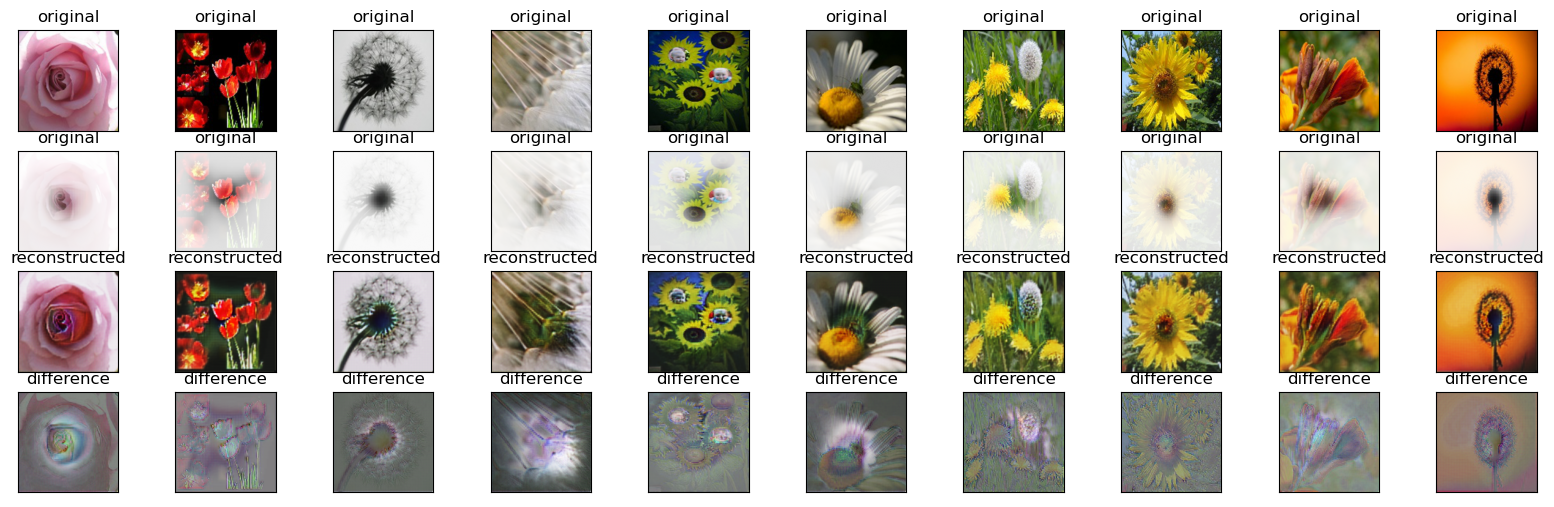

In [16]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(4, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(y_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(4, n, i + n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(4, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs_ts[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display difference
    cx = plt.subplot(4, n, i + 3*n + 1)
    plt.title("difference")
    difference_im = y_test[i] - decoded_imgs_ts[i]
    norm_difference_im = (difference_im - np.min(difference_im))/(np.max(difference_im)-np.min(difference_im))
    plt.imshow(tf.squeeze(norm_difference_im))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

plt.show()
plt.savefig(path_results + f'/Unet_comparison_ts.png', bbox_inches='tight', format='png')
plt.close() 

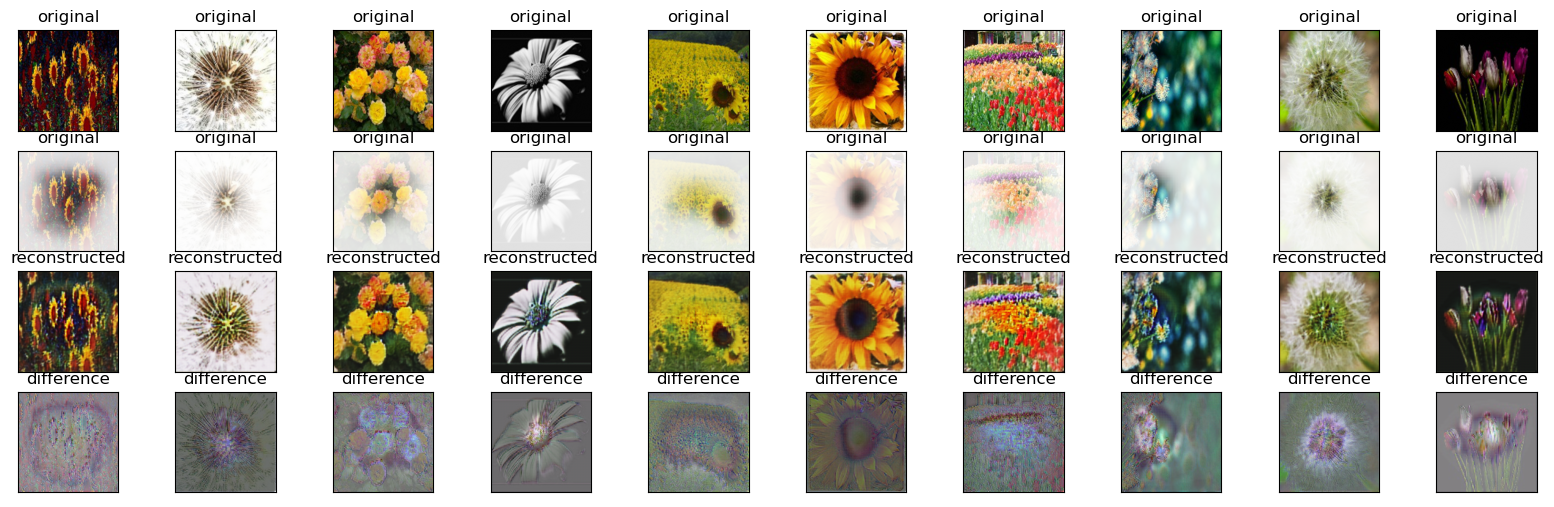

In [17]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(4, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(y_train[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(4, n, i + n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_train[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(4, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs_tr[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    # display difference
    cx = plt.subplot(4, n, i + 3*n + 1)
    plt.title("difference")
    difference_im = y_train[i] - decoded_imgs_tr[i]
    norm_difference_im = (difference_im - np.min(difference_im))/(np.max(difference_im)-np.min(difference_im))
    plt.imshow(tf.squeeze(norm_difference_im))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

plt.show()
plt.savefig(path_results + f'/Unet_comparison_tr.png', bbox_inches='tight', format='png')
plt.close() 

In [ ]:
encoded_all = autoencoder.encoder(X).numpy()
decoded_all = autoencoder.decoder(encoded_all).numpy()

# Save the prediction:
for i, pred_i in enumerate(decoded_all):
    print(i)
    plt.axis('off')
    plt.imshow(pred_i)
    plt.savefig(path_results + f'/Unet_ims/pred_{i}.png', bbox_inches='tight', format='png')
    plt.close()

    plt.axis('off')
    difference_im = X[i] - decoded_all[i]
    norm_difference_im = (difference_im - np.min(difference_im))/(np.max(difference_im)-np.min(difference_im))
    plt.imshow(tf.squeeze(norm_difference_im))
    plt.savefig(path_results + f'/diff_ims/diff_{i}.png', bbox_inches='tight', format='png')
    plt.close()

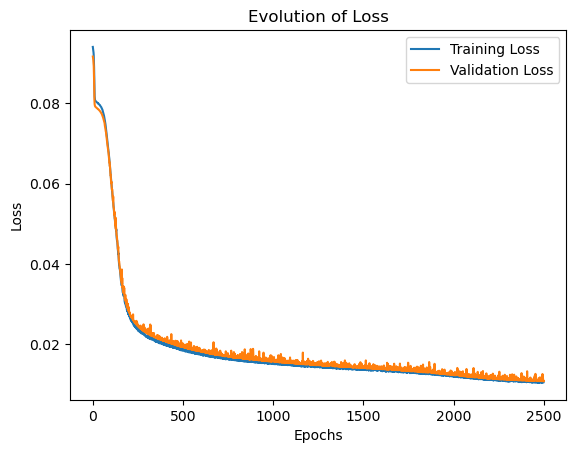

In [19]:
plt.plot(train_loss, label="Training Loss")
plt.plot(valid_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Evolution of Loss")
plt.legend()
plt.savefig(path_results + f'/evol_of_error_Unet.png', bbox_inches='tight', format='png')